# Test reconstruction

Script to test for reconstruction of MRI data for a different number of timepoints, plotting, etc

In [1]:
#Import
# working dir
%cd /homedtic/gmarti/CODE/RNN-VAE/

# Imports
import sys
sys.path.insert(0, '/homedtic/gmarti/CODE/RNN-VAE/')
from rnnvae.utils import open_MRI_data_var
from rnnvae import rnnvae
from rnnvae.plot import plot_losses, plot_trajectory, plot_total_loss, plot_z_2d, plot_z_time_2d
import os
import math
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import torch

%matplotlib inline

/homedtic/gmarti/CODE/RNN-VAE


In [2]:
import torch


In [6]:
# DEVICE
## Decidint on device on device.
DEVICE_ID = 0
DEVICE = torch.device('cuda:' + str(DEVICE_ID) if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.cuda.set_device(DEVICE_ID)

out_dir = "experiments/meta_mri_lin_pad/_h_2_z_3_hid_5_l_2/"

#load parameters
p = eval(open(out_dir + "params.txt").read())

#Seed
torch.manual_seed(p["seed"])
np.random.seed(p["seed"])

p['x_size'] = 40

model = rnnvae.ModelRNNVAE(p["x_size"], p["h_size"], p["hidden"], p["n_layers"], 
                        p["hidden"], p["n_layers"], p["hidden"],
                        p["n_layers"], p["z_dim"], p["hidden"], p["n_layers"],
                        p["clip"], p["n_epochs"], p["batch_size"], DEVICE)
model.load(out_dir+'model.pt')
model = model.to(DEVICE)

For a specific value, generate it for a given number of timepoints and plot it

In [15]:
csv_path = "data/tadpole_mrionly.csv"
X_train, X_test, Y_train, Y_test = open_MRI_data_var(csv_path, train_set=0.9, normalize=True, return_covariates=True)

nfeatures = X_train[0].shape[1]

# Apply padding to both X_train and X_val
X_train_tensor = [ torch.FloatTensor(t) for t in X_train ]
X_train_pad = torch.nn.utils.rnn.pad_sequence(X_train_tensor, batch_first=False, padding_value=np.nan)
X_test_tensor = [ torch.FloatTensor(t) for t in X_test ]
X_test_pad = torch.nn.utils.rnn.pad_sequence(X_test_tensor, batch_first=False, padding_value=np.nan)

# Those datasets are of size [Tmax, Batch_size, nfeatures]
mask_train = ~torch.isnan(X_train_pad)
mask_test = ~torch.isnan(X_test_pad)

#convert those NaN to zeros
X_train_pad[torch.isnan(X_train_pad)] = 0
X_test_pad[torch.isnan(X_test_pad)] = 0

max_timepoints = X_train_pad.shape[0]
# Those datasets are of size [Tmax, Batch_size, nfeatures]
# Predict the reconstructions from X_val and X_train
X_test_fwd = model.predict(X_test_pad.to(DEVICE))
X_train_fwd = model.predict(X_train_pad.to(DEVICE))

And now, plot it!

(8, 40)


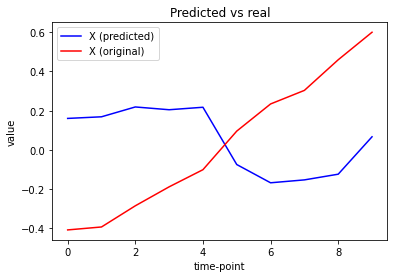

In [38]:
# Test reconstruction of samples
#Generate data, with different parameters

#Reformulate things
X_test_hat = np.array(X_train_fwd['xnext']).swapaxes(0,1)
X_test_hat = [X[mask_train[:,i,:]].reshape((-1, p["x_size"])) for (i, X) in enumerate(X_test_hat)]

feat = 37
subj = 5

print(X_test_hat[0].shape)

X_hat_line = X_test_hat[subj][:,feat]   #Select only the subject we want
X_samples_line = X_train[subj][:,feat]   #Select only the subject we want

# Plot the two lines
plt.plot(range(len(X_hat_line)), X_hat_line, '-b', label='X (predicted)')
plt.plot(range(len(X_samples_line)), X_samples_line, '-r', label='X (original)')

plt.xlabel("time-point")
plt.ylabel("value")

plt.legend(loc='upper left')
plt.title("Predicted vs real")
plt.show()

(500, 30, 5)
(500, 15, 5)
(500, 30, 5)
(500, 15, 5)


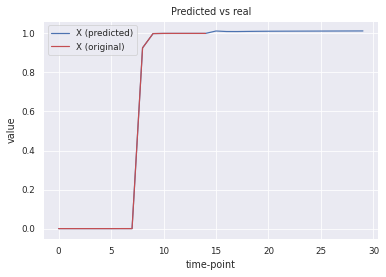

In [78]:
# Predict the reconstructions from X_val and X_train
extra_nt = 30
X_fwd = model.sequence_predict(X_samples_tensor.to(DEVICE), extra_nt)

#Reformulate things
X_fwd['xnext'] = np.array(X_fwd['xnext']).swapaxes(0,1)
X_fwd['z'] = np.array(X_fwd['z']).swapaxes(0,1)

X_hat = X_fwd["xnext"]

feat = 4
subj = 0

print(X_hat.shape)
print(X_samples.shape)
X_hat_line = X_hat[subj,:,feat]   #Select only the subject we want
X_samples_line = X_samples[subj,:,feat]   #Select only the subject we want
print(X_hat.shape)
print(X_samples.shape)
# Plot the two lines
plt.plot(range(len(X_hat_line)), X_hat_line, '-b', label='X (predicted)')
plt.plot(range(len(X_samples_line)), X_samples_line, '-r', label='X (original)')

plt.xlabel("time-point")
plt.ylabel("value")

plt.legend(loc='upper left')
plt.title("Predicted vs real")
plt.show()

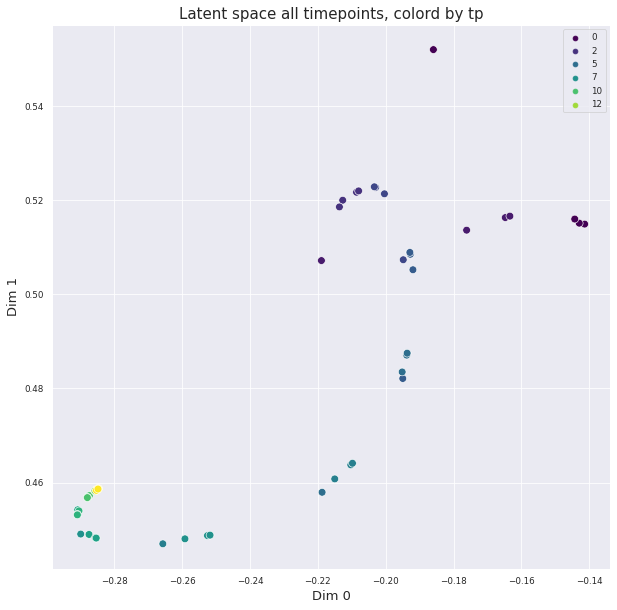

In [8]:
# Plot the latent space
dim0 = 0
dim1 = 1

plt.figure(figsize=(10, 10))
# create color cmap
pallete = sns.color_palette("viridis", n_rec_tp)

z_d0_full = []
z_d1_full = []
tp_full = []
for tp in range(n_rec_tp):

    z_d0 = [x[tp, dim0] for x in recon_zx if x.shape[0] > tp]
    z_d1 = [x[tp, dim1] for x in recon_zx if x.shape[0] > tp]

    #populate 
    z_d0_full = z_d0_full + z_d0
    z_d1_full = z_d1_full + z_d1
    tp_full = tp_full + [tp]*(len(z_d0))


sns.scatterplot(x=z_d0_full,y=z_d1_full,hue=tp_full, palette="viridis", s=60)
##Add title, x and y axis
plt.xlabel(f"Dim {dim0}", size=13)
plt.ylabel(f"Dim {dim1}", size=13)
plt.title(f"Latent space all timepoints, colord by tp", size=15)
plt.show()

Now, try to do a large number of samples from the same initial subsample, and see how they vary.

In [8]:
n_iter = 1000

x_full_samples = np.zeros((n_iter, n_rec_tp, p['x_size']))
z_full_samples = np.zeros((n_iter, n_rec_tp, p['z_dim']))

for n in range(n_iter):
    
    #generate for initial position
    samples = gen_model.generate_n_samples(n_generated_samples)
    X_samples = np.asarray([y for (_,y) in samples])
    X_samples_tensor = torch.FloatTensor(X_samples).permute((1,0,2))
    X_sample = model.sequence_predict(X_samples_tensor.to(DEVICE), n_rec_tp)
    
    
    #Sample from prior, no input
    #X_sample = model.sample_latent(1, n_rec_tp)
    
    recon_x = np.array(X_sample['xnext']).swapaxes(0,1)
    recon_zx = np.array(X_sample['z']).swapaxes(0,1)
    x_full_samples[n, :, :] = recon_x
    z_full_samples[n, :, :] = recon_zx

ValueError: could not broadcast input array from shape (500,15,5) into shape (15,5)

In [ ]:
#Plot it against time points (horizontally)
feat = 0
sns.set_theme()
sns.set_context("paper")

# create figure, plot it
plt.figure(figsize=(10,10))
for line in x_full_samples:
    plt.plot(list(range(len(line[:, feat]))), line[:, feat], linewidth=0.5)

plt.xlabel("time-point")
plt.ylabel("value")
plt.show()

In [ ]:
# Plot latent space
dim0 = 1
dim1 = 0

plt.figure(figsize=(10, 10))
# create color cmap
pallete = sns.color_palette("viridis", n_rec_tp)

z_d0_full = []
z_d1_full = []
tp_full = []
for tp in range(n_rec_tp):

    z_d0 = [x[tp, dim0] for x in z_full_samples if x.shape[0] > tp]
    z_d1 = [x[tp, dim1] for x in z_full_samples if x.shape[0] > tp]

    #populate 
    z_d0_full = z_d0_full + z_d0
    z_d1_full = z_d1_full + z_d1
    tp_full = tp_full + [tp]*(len(z_d0))


sns.scatterplot(x=z_d0_full,y=z_d1_full,hue=tp_full, palette="viridis", s=60)
##Add title, x and y axis
plt.xlabel(f"Dim {dim0}", size=13)
plt.ylabel(f"Dim {dim1}", size=13)
plt.title(f"Latent space all timepoints, colord by tp", size=15)
plt.show()